# 导入相关模块

In [1]:
import json # 处理json格式的数据
import requests # 发起网络请求
import pandas as pd # 优秀的分析数据工具
import numpy as np # 处理数字的工具
import matplotlib.pyplot as plt # 强大的画图工具

In [2]:
def run():
    ''' 主程序, 用来调度各个重要流程 '''
    kline = load_sse()
    df = init_df(kline)
    df = strategy(df)
    df = backtest(df)
    draw(df)
    df.to_csv('./result.csv', index = False)

In [3]:
def load_sse():
    ''' 进行网络请求，获取上交所的上证指数K线数据'''
    response = requests.get(
        'http://yunhq.sse.com.cn:32041/v1/sh1/dayk/600519?callback=jQuery111205234775875526079_1542185571865&select=date%2Copen%2Chigh%2Clow%2Cclose%2Cvolume&begin=-500&end=-1&_=1542185571881',
        headers={'Referer': 'http://www.sse.com.cn/market/price/trends/'}
    )

    # 针对结果进行格式处理
    json_str = response.text[42:-1]
    data = json.loads(json_str)
    return data['kline']

In [4]:
def init_df(kline):
    ''' 根据K线数据，创建含有日期与收盘价的矩阵 '''
    df = pd.DataFrame({})
    df['date'] =  [x[0] for x in kline] #提取交易日期，成为列表
    df['close'] = [x[2] for x in kline] #提取收盘价，成为列表

    return df

In [5]:
def strategy(df):
    ''' 根据价格计算平均值，然后把策略记录下来 '''

    # 连续15天数据，计算平均值，作为当天的平均价格指标
    window_size = 15
    df['avg'] = df['close'].rolling(window_size).apply(lambda x: sum(x) / len(x), raw=True)

    def avg_buy(x):
        ''' 做多策略 '''

        # 追涨杀跌的策略，
        min_percent = 0.995
        max_percent = 1.005
        # 追涨，当我们的价格超过了均线一定程度时，买股票，追涨
        if (x[1] / x[0]) < min_percent:
            return 'open buy'
        # 杀跌，当我们的价格低于均线一定程度时，卖股票，杀跌
        if (x[1] / x[0]) > max_percent:
            return 'close buy'
        # 其他情况不操作
        return 'wait'

    df['action'] = df[['close', 'avg']].apply(avg_buy, axis=1)
    return df

In [6]:
def backtest(df):
    ''' 回归测试 '''
    global shares, cash
    amount = 1000000 #设置100万初始资金
    shares = 0
    cash = amount

    def run_strategy(row):
        ''' 把每天的数据执行策略 '''
        global shares, cash
        action = row['action']
        close = row['close']

        # 资产 = 现金 + 股票价值
        liquidate = cash + shares * close
        message = 'nothing'

        # 策略要求开仓做多，而且当前空仓时，做多
        if action == 'open buy' and shares == 0:
            shares = int(cash / close)
            cash -= shares * close
            message = 'open buy ' + str(shares)

        # 策略要求平仓，而且当前有仓时，平掉
        if action == 'close buy' and shares > 0:
            message = 'close buy ' + str(shares)
            cash += shares * close
            shares = 0
        print(shares, cash, liquidate)
        return [message, shares, cash, liquidate]

    rows = df[['close', 'action']].apply(run_strategy, axis=1)
    df['message'], df['shares'], df['cash'], df['liquidate'] = zip(*rows)
    return df

In [7]:
def draw(df):
    ''' 画图 '''
    # 创建画板
    fig = plt.figure(figsize=(10, 5))

    # 准备横坐标
    count = df.count()['close']
    index = np.arange(count)
    df['index'] = index

    # 设置横坐标的刻度与显示标签
    limit = 200
    plt.xticks(index[::limit], df['date'][::limit])

    # 收盘价与资产的两套坐标系
    ax_close = plt.gca()
    ax_liquidate = ax_close.twinx()

    # 画收盘价曲线
    ax_close.set(xlabel='Date', ylabel='close')
    l_close, = ax_close.plot(index, df['close'], 'black', label='close')
    l_avg, = ax_close.plot(index, df['avg'], 'pink', label='avg')

    # 画资产曲线
    ax_liquidate.set(ylabel = 'liquidate')
    l_liquidate, = ax_liquidate.plot(index, df['liquidate'], 'blue', label='liquidate')

    def drawAction(row):
        if row['message'] == 'nothing':
            return

        color = ''
        marker = 'o'
        size = 12

        if row['action'] == 'open buy':
            color='r'
        if row['action'] == 'close buy':
            color='g'

        ax_close.scatter(row['index'], row['close'], s=size, color=color, zorder=2, marker=marker)

    df[['index', 'action', 'message', 'close']].apply(drawAction, axis=1)

    # 给两条线都提供一个图例说明
    plt.legend(handles=[l_close, l_avg, l_liquidate])
    plt.show()

0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
0 1000000 1000000.0
1454 665.8000000000466 1000000.0
1454 665.8000000000466 1009421.92
1454 665.8000000000466 1002297.3200000001
1454 665.8000000000466 1007706.2000000001
1454 665.8000000000466 985023.8
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
0 971457.98 971457.98
1454 185.97999999998137 971457.98
1454 185.97999999998137 997629.98
1454 185.97999999998137 998938.58
1454 185.97999999998137 1018000.52
1454 185.97999999998137 1026375.5599999999
1454 185.97999999998137 1065502.7
1454 185.979999999981

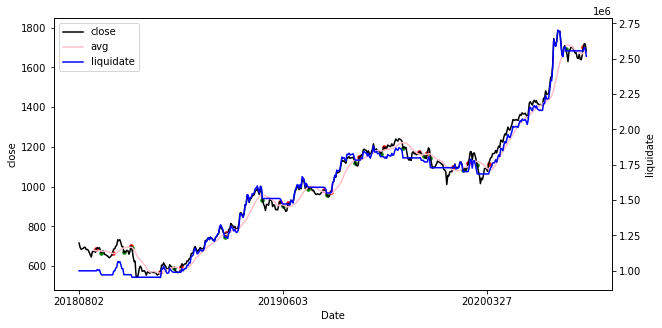

In [8]:
if __name__ == '__main__':
    run()

可以看到，在2018.7.1-2020.7.1期间，我们从最初的本金100万，达到了最终总资产251.75万元